# Movie Reviews - Sentiment Classification

## Overview
This notebook performs sentiment analysis on the NLTK Movie Reviews dataset using feature extraction and logistic regression. The goal is to classify reviews as positive or negative based on custom and automated features.


In [ ]:
!pip install contractions
!pip install emoji
!pip install textstat

In [ ]:
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [ ]:
# Display the first 5 fileids in the movie_reviews corpus
movie_reviews.fileids()[:5]

['neg/cv000_29416.txt',
 'neg/cv001_19502.txt',
 'neg/cv002_17424.txt',
 'neg/cv003_12683.txt',
 'neg/cv004_12641.txt']

We see that the first five documents are txt files. Hence we will read the reviews from each document in later steps

In [ ]:
# Total number of reviews
len(movie_reviews.fileids())

2000

In [ ]:
# Review categories
movie_reviews.categories()

['neg', 'pos']

In [ ]:
# Total number of positive reviews
num_positive_reviews = len(movie_reviews.fileids('pos'))
num_positive_reviews

1000

In [ ]:
# Total number of positive reviews
num_negative_reviews = len(movie_reviews.fileids('neg'))
num_negative_reviews

1000

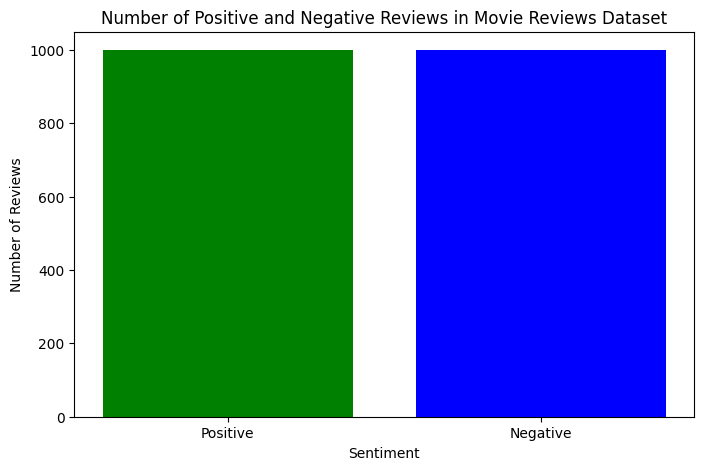

In [ ]:
# Plot the number of positive and negative reviews with matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(['Positive', 'Negative'], [num_positive_reviews, num_negative_reviews], color=['green', 'blue'])
plt.title('Number of Positive and Negative Reviews in Movie Reviews Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
# Access the movie_reviews dataset
# Iterate over categories, iterate over every document in each category,
# create a list of tuples ([tokens for reviews], [category name of reviews])

documents = [(movie_reviews.words(fileid), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

In [ ]:
# shuffling since first 5 are 'neg'
import random
random.shuffle(documents)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import contractions
import emoji
from nltk.sentiment.util import mark_negation
from nltk import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Preprocessing

STOP = set(stopwords.words('english'))
LEMMAT = WordNetLemmatizer()
PUNCT = set(string.punctuation)

def preprocess(words):
    # contractions - don't to do not
    tokens = [contractions.fix(w) for w in words]
    # lowercase
    tokens = [w.lower() for w in tokens]
    # convert emoji to tect
    tokens = [emoji.demojize(w) for w in tokens]
    # remove punctuation-only tokens
    tokens = [w for w in tokens if not (all(ch in string.punctuation for ch in w) and w not in {'!', '?', '/'})]
    # lemmatize
    tokens = [LEMMAT.lemmatize(w) for w in tokens]
    # Negation Marking
    #tokens = mark_negation(tokens) # can be improved to only tag sentiments (adjectives and verbs)
    # remove stopwords
    tokens = [w for w in tokens if w not in STOP]
    return tokens

#can also add tokeniser here instead of breaking the reviews into words - need to check which is better - words or default token library

**Feature Extraction**

In [ ]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from sklearn.feature_extraction.text import TfidfVectorizer

docs = [' '.join(movie_reviews.words(feild)) for feild in movie_reviews.fileids()]

# Top 2000 unigrams
all_words = nltk.FreqDist(word.lower() for word in movie_reviews.words())
word_features = [word for word, _ in all_words.most_common(2000)]

# Top 500 bigrams by likelihood ratio
bigram_finder = BigramCollocationFinder.from_words(word.lower() for word in movie_reviews.words())
bigram_features = bigram_finder.nbest(BigramAssocMeasures.likelihood_ratio, 500)

# Top TF-IDF terms
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(docs)
tfidf_features = vectorizer.get_feature_names_out()


In [ ]:
import textstat
from collections import Counter
from nltk import bigrams, trigrams, pos_tag
from textstat import syllable_count

NEG_WORDS = {'not','never','no','nothing'}
COMPARATIVE_TAGS = {'JJR'}    # comparitive adjectives: e.g. “better”
SUPERLATIVE_TAGS = {'JJS'}    # superlative adjectives: e.g. “best”
DISCOURSE_MARKERS = {'however','although','instead','therefore', 'even though'}

def features_tuning(tokens):
    """
    tokens: list of preprocessed tokens (strings)
    returns: dict of feature_name -> value
    """
    features = {}
    cnt = Counter(tokens)
    token_set = set(tokens)
    text = " ".join(tokens)

    # Bag-of-Words presence
    for w in word_features:
        features[f"bow({w})"] = (w in token_set)

    # Bag-of-Bigrams presence
    toks_bigrams = list(bigrams(tokens))
    for bg in bigram_features:
        features[f"bigram({bg[0]}_{bg[1]})"] = (bg in toks_bigrams)

    # TF–IDF top terms presence
    for t in tfidf_features:
        features[f"tfidf({t})"] = (t in token_set)

    # Punctuation counts
    features['exclaim_count']   = cnt['!']
    features['question_count']  = cnt['?']

    # “but” contrast
    features['but_present'] = (cnt['but']>0)

    # Comparatives & superlatives
    tagged = pos_tag(tokens)
    features['comparatives']  = sum(1 for _,pos in tagged if pos in COMPARATIVE_TAGS)
    features['superlatives']  = sum(1 for _,pos in tagged if pos in SUPERLATIVE_TAGS)

    # Discourse markers
    for dm in DISCOURSE_MARKERS:
        features[f"disc_{dm}"]   = (dm in token_set)
        features['disc_even_though'] = ('even','though') in list(bigrams(tokens))

    # Rhetorical questions
    # count “why?” or “how?” style occurrences
    features['why_q']  = 'why' in tokens and cnt['?']>0
    features['how_q']  = 'how' in tokens and cnt['?']>0



    return features

In [ ]:
documents_raw = [(movie_reviews.raw(f), movie_reviews.categories(f)[0]) for f in movie_reviews.fileids()]

# Extract text and categories into separate lists
X = [review for review, category in documents_raw]
y = [category for review, category in documents_raw]

In [ ]:
# import random
# random.shuffle(documents)

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
# splitting into train, test and development sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.80 = 0.20

In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
# Preprocess & featurize
X_train_features = [features_tuning(preprocess(nltk.word_tokenize(str(doc)))) for doc in X_train]
X_dev_features = [features_tuning(preprocess(nltk.word_tokenize(str(doc)))) for doc in X_dev]
#X_test_features = [features_tuning(preprocess(nltk.word_tokenize(str(doc)))) for doc in X_test]

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score

dv    = DictVectorizer(sparse=True)
X_tr   = dv.fit_transform(X_train_features)
X_de   = dv.transform  (X_dev_features)
#X_te   = dv.transform  (X_test_features)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_tr, y_train)

clf.score(X_tr, y_train) # to check overfitting

1.0

In [ ]:
print(classification_report(y_dev, clf.predict(X_de)))

              precision    recall  f1-score   support

         neg       0.82      0.87      0.84       199
         pos       0.86      0.81      0.83       201

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



In [ ]:
# fine tune hyperparamenters and fixing preprocessing step

# Preprocessing

STOP = set(stopwords.words('english'))
LEMMAT = WordNetLemmatizer()
PUNCT = set(string.punctuation)

def preprocess(words):
    # contractions - don't to do not
    tokens = [contractions.fix(w) for w in words]
    # lowercase
    tokens = [w.lower() for w in tokens]
    # convert emoji to tect
    tokens = [emoji.demojize(w) for w in tokens]
    # remove punctuation-only tokens
    tokens = [w for w in tokens if not (all(ch in string.punctuation for ch in w) and w not in {'!', '?', '/'})]
    # lemmatize
    tokens = [LEMMAT.lemmatize(w) for w in tokens]
    # Negation Marking
    #tokens = mark_negation(tokens) # can be improved to only tag sentiments (adjectives and verbs) # removing this
    # remove stopwords
    tokens = [w for w in tokens if w not in STOP]
    return tokens

#can also add tokeniser here instead of breaking the reviews into words - need to check which is better - words or default token library

In [ ]:
import textstat
from collections import Counter
from nltk import bigrams, trigrams, pos_tag
from textstat import syllable_count

NEG_WORDS = {'not','never','no','nothing'}
COMPARATIVE_TAGS = {'JJR'}    # comparitive adjectives: e.g. “better”
SUPERLATIVE_TAGS = {'JJS'}    # superlative adjectives: e.g. “best”
DISCOURSE_MARKERS = {'however','although','instead','therefore', 'even though'}

def improved_features_tuning(tokens):
    """
    tokens: list of preprocessed tokens (strings)
    returns: dict of feature_name -> value
    """
    features_improved = features_tuning(tokens)
    #cnt = Counter(tokens)
    #token_set = set(tokens)
    #text = " ".join(tokens)

    # Count how many trigrams start with a NEG_WORD
    neg_trigram_counts = Counter(
        (w2, w3)
        for (w1, w2, w3) in trigrams(tokens)
        if w1 in NEG_WORDS
    )
    # count of all negation trigrams
    features_improved['neg_trigram_total'] = sum(neg_trigram_counts.values())

    return features_improved

In [ ]:
best_f1, best_C = 0, None
for C in [0.01, 0.1, 1, 10]:
    clf = LogisticRegression(C=C, max_iter=1000)
    clf.fit(X_tr, y_train)
    f1 = f1_score(y_dev, clf.predict(X_de), average='weighted')
    if f1 > best_f1:
        best_f1, best_C = f1, C
print("Dev‐tuned C:", best_C, "→ F1:", best_f1)


Dev‐tuned C: 0.01 → F1: 0.84984235812231


In [ ]:
# Preprocess & featurize
X_train_features = [improved_features_tuning(preprocess(nltk.word_tokenize(str(doc)))) for doc in X_train]
X_dev_features = [improved_features_tuning(preprocess(nltk.word_tokenize(str(doc)))) for doc in X_dev]
X_test_features = [improved_features_tuning(preprocess(nltk.word_tokenize(str(doc)))) for doc in X_test]

In [ ]:
#from sklearn.feature_extraction import DictVectorizer
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import accuracy_score, classification_report, f1_score

dv    = DictVectorizer(sparse=True)
X_tr   = dv.fit_transform(X_train_features)
X_de   = dv.transform  (X_dev_features)
X_te   = dv.transform  (X_test_features)

#clf = LogisticRegression(max_iter=1000)
#clf.fit(X_tr, y_train)

#clf.score(X_tr, y_train) # to check overfitting

In [ ]:
# combine features & labels
X_full_feats = X_train_features + X_dev_features
y_full       = list(y_train) + list(y_dev)

# vectorize
X_full = dv.fit_transform(X_full_feats)

# fit final
clf_final = LogisticRegression(max_iter=1000, C = best_C)
clf_final.fit(X_full, y_full)


LogisticRegression(C=0.01, max_iter=1000)

In [ ]:
X_test = dv.transform(X_test_features)
y_pred = clf_final.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         neg       0.82      0.81      0.82       199
         pos       0.82      0.83      0.82       201

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



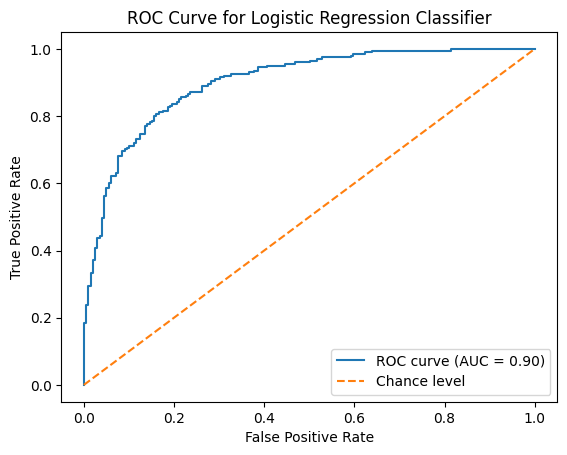

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 1) Convert your test labels to binary
y_test_binary = [1 if label == 'pos' else 0 for label in y_test]

# 2) Get predicted probabilities for the positive class
y_prob = clf_final.predict_proba(X_test)[:, 1]

# 3) Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_binary, y_prob)
roc_auc = auc(fpr, tpr)

# 4) Plot
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Chance level')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Classifier')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
len(X_train)

1200

In [ ]:
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
dv = DictVectorizer(sparse=True)
X_train_counts = dv.fit_transform(X_train_features)
X_test_counts = dv.transform(X_test_features)

# 3) Extract the feature names (these are your “vocabulary” of handcrafted features)
feature_names = dv.get_feature_names_out()

# 4) Fit the tf–idf transformer on the TRAINING counts
tfidf_tr      = TfidfTransformer(norm=None)          # norm=None keeps raw tf–idf
X_train_tfidf    = tfidf_tr.fit_transform(X_train_counts)  # learns IDF from training data

# 5) Transform the TEST counts into tf–idf
X_test_tfidf  = tfidf_tr.transform(X_test_counts)

# 6) Build a DataFrame for the TRAINING tf–idf matrix
df_tfidf_train = pd.DataFrame(X_train_tfidf.toarray(), columns = feature_names)
df_tfidf_train

,bigram(!_!),"bigram(!_"")",bigram(!_)),bigram(&_nbsp),bigram('_'),"bigram('_,)",bigram('_.),bigram('_a),bigram('_and),bigram('_d),...,tfidf(wrote),tfidf(yeah),tfidf(year),tfidf(years),tfidf(yes),tfidf(york),tfidf(young),tfidf(younger),tfidf(zero),why_q
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 7) Likewise for the TEST split
df_tfidf_test = pd.DataFrame(X_test_tfidf.toarray(), columns = feature_names)
df_tfidf_test

,bigram(!_!),"bigram(!_"")",bigram(!_)),bigram(&_nbsp),bigram('_'),"bigram('_,)",bigram('_.),bigram('_a),bigram('_and),bigram('_d),...,tfidf(wrote),tfidf(yeah),tfidf(year),tfidf(years),tfidf(yes),tfidf(york),tfidf(young),tfidf(younger),tfidf(zero),why_q
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def normalize(text):
    tokens = preprocess(nltk.word_tokenize(text)) #preprocess step from before

     # Remove punctuation-only tokens
    tokens = [t for t in tokens if not all(c in string.punctuation for c in t)]

    # Removing numbers from reviews
    tokens = [t for t in tokens if not t.isdigit()]

    # Removing first person pronouns
    tokens = [t for t in tokens if t.lower() not in ['i', 'me', 'my', 'mine', 'myself']]

    # Removing _NEG tags
    tokens = [t for t in tokens if not t.endswith('_NEG')]

    return tokens

In [ ]:
#
vectorizer = TfidfVectorizer(analyzer=normalize, token_pattern=None)
X_tfidf = vectorizer.fit_transform(X_train)

# Get the vocabulary (terms)
terms = vectorizer.get_feature_names_out()

# Convert the TF–IDF sparse matrix to a dense array
#    and build a DataFrame whose columns are the term names:
df_tfidf = pd.DataFrame(
    X_tfidf.toarray(),    # shape: (n_docs, n_terms)
    columns=terms
)

# Inspect
print(df_tfidf.shape)
print(df_tfidf)  #


(1200, 32759)
          goodies  suspend  they  white               are   will  \
0     0.0       0.0       0.0    0.0      0.0  0.0  0.0  0.000000    0.0   
1     0.0       0.0       0.0    0.0      0.0  0.0  0.0  0.000000    0.0   
2     0.0       0.0       0.0    0.0      0.0  0.0  0.0  0.000000    0.0   
3     0.0       0.0       0.0    0.0      0.0  0.0  0.0  0.000000    0.0   
4     0.0       0.0       0.0    0.0      0.0  0.0  0.0  0.000000    0.0   
...   ...       ...       ...    ...      ...  ...  ...       ...    ...   
1195  0.0       0.0       0.0    0.0      0.0  0.0  0.0  0.000000    0.0   
1196  0.0       0.0       0.0    0.0      0.0  0.0  0.0  0.000000    0.0   
1197  0.0       0.0       0.0    0.0      0.0  0.0  0.0  0.028588    0.0   
1198  0.0       0.0       0.0    0.0      0.0  0.0  0.0  0.000000    0.0   
1199  0.0       0.0       0.0    0.0      0.0  0.0  0.0  0.000000    0.0   

         would  ...  zorg  zorro  zucker  zuehlke  zuko  zulu  zweibel  z